# Adam Thomson - PHY573 - Week 2

## Quantum Teleportation

Follow along with qiskit tutorial for quantum teleportation
https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/teleportation.ipynb

### Setup the session

In [189]:
# Import libraies
from IPython.display import Math
from qiskit import \
    transpile, \
    QuantumCircuit as QCir, \
    QuantumRegister as QReg, \
    ClassicalRegister as CReg
from qiskit.circuit.library import Initialize
from qiskit.result import marginal_counts
from qiskit.quantum_info import random_statevector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import \
    plot_histogram, \
    plot_bloch_multivector, \
    array_to_latex
from qiskit_ibm_runtime import \
    QiskitRuntimeService, \
    SamplerV2

from qiskit_aer import AerSimulator

In [190]:
# Setup local backend simulator for testing circuits
aer_simulator = AerSimulator()

# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)

sampler = SamplerV2(mode=backend)
sampler.options.default_shots = 1_000

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=1)

### Create the quantum circuit

In [191]:
# Circuit uses 3 qubits and 2 classical bits (on separate registers)

qr = QReg(3, name="q")
crz = CReg(1, name="crz")
crx = CReg(1, name="qrx")
teleportation_circuit = QCir(qr, crz, crx)

Start by creating a Bell state and splitting the pair of qubits, assigning one to Alice (a) and the other to Bob (b). This Bell State utilizes a Hadamard gate (to put one qubit into a super position) and a CNOT gate with the super position qubit as the control. Assuming the circuit starts from the initial state |00>, this produces the inseparable 2-qubit state (1/sqrt(2))*(|00> + |11>)

In [192]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a)     # Put qubit a into state |+>
    qc.cx(a, b) # Entangle a with b via CNOT

In [193]:
# Step 1: Entangle q1 and q2
create_bell_pair(teleportation_circuit, 1, 2)
teleportation_circuit.draw()

q_0: ──────────
       ┌───┐     
  q_1: ┤ H ├──■──
       └───┘┌─┴─┐
  q_2: ─────┤ X ├
            └───┘
crz: 1/══════════
                 
qrx: 1/══════════

Alice takes q1, Bob takes q2, and they separate. Later, Alice wants to send Bob some |psi> in q0. She does this by applying CNOT and H gates to her qubits, taking a measurement, and sending classical bits to Bob.

In [194]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

In [195]:
# Step 2: Alice entangles her half of Bell pair with q0
teleportation_circuit.barrier()
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw()

░      ┌───┐
  q_0: ───────────░───■──┤ H ├
       ┌───┐      ░ ┌─┴─┐└───┘
  q_1: ┤ H ├──■───░─┤ X ├─────
       └───┘┌─┴─┐ ░ └───┘     
  q_2: ─────┤ X ├─░───────────
            └───┘ ░           
crz: 1/═══════════════════════
                              
qrx: 1/═══════════════════════

In [196]:
def measure_to_creg(qc, a, b):
    """Measure qubits a&b on circuit qc"""
    qc.measure(a,0)
    qc.measure(b,1)

In [197]:
# Step 3 : Alice measures q0 and q1 to classical register for Bob to read
measure_to_creg(teleportation_circuit, 0, 1)
teleportation_circuit.draw()

░      ┌───┐┌─┐
  q_0: ───────────░───■──┤ H ├┤M├
       ┌───┐      ░ ┌─┴─┐└┬─┬┘└╥┘
  q_1: ┤ H ├──■───░─┤ X ├─┤M├──╫─
       └───┘┌─┴─┐ ░ └───┘ └╥┘  ║ 
  q_2: ─────┤ X ├─░────────╫───╫─
            └───┘ ░        ║   ║ 
crz: 1/════════════════════╬═══╩═
                           ║   0 
qrx: 1/════════════════════╩═════
                           0

Bob now uses the state of the classical register as controls for CNOT on his qubit.

In [198]:
def bob_gates(qc, qubit, crz, crx):
    """Takes a qubit as input as well as 2 classical bits to use as controls"""
    with qc.if_test((crx, 1)) as else_:
        qc.x(qubit)
    with qc.if_test((crz, 1)) as else_:
        qc.z(qubit)

In [199]:
# Step 4: Bob uses classical register as controls for CX and CZ gates
teleportation_circuit.barrier()
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw()

░      ┌───┐┌─┐ ░                                     »
  q_0: ───────────░───■──┤ H ├┤M├─░─────────────────────────────────────»
       ┌───┐      ░ ┌─┴─┐└┬─┬┘└╥┘ ░                                     »
  q_1: ┤ H ├──■───░─┤ X ├─┤M├──╫──░─────────────────────────────────────»
       └───┘┌─┴─┐ ░ └───┘ └╥┘  ║  ░ ┌────── ┌───┐ ───────┐ ┌────── ┌───┐»
  q_2: ─────┤ X ├─░────────╫───╫──░─┤ If-0  ┤ X ├  End-0 ├─┤ If-0  ┤ Z ├»
            └───┘ ░        ║   ║  ░ └──╥─── └───┘ ───────┘ └──╥─── └───┘»
                           ║   ║       ║                   ┌──╨──┐      »
crz: 1/════════════════════╬═══╩═══════╬═══════════════════╡ 0x1 ╞══════»
                           ║   0    ┌──╨──┐                └─────┘      »
qrx: 1/════════════════════╩════════╡ 0x1 ╞═════════════════════════════»
                           0        └─────┘                             »
«                 
«  q_0: ──────────
«                 
«  q_1: ──────────
«        ───────┐ 
«  q_2:   End-0 ├─
«        ───────┘ 
«crz: 1/══════════
«                 
«qrx: 1/══════════
«

Ta-da! Now bob's qubit, q2, is in state |psi>. Notably, Alice's original qubit |psi> has been measured and is no longer in a superposition, thus we have "teleported" the quantum state instead of copying it.

### 3. Simulating the Teleportation Protocol

<IPython.core.display.Latex object>

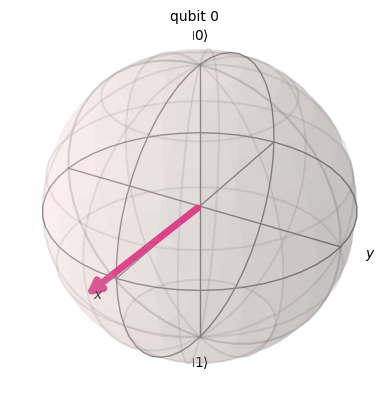

In [200]:
# Create a random 1-qubit state
psi = random_statevector(2)

# Display as equation and on Bloch Sphere
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
plot_bloch_multivector(psi)

Create an 'instruction' to set a qubit to psi to test out teleportation.

In [201]:
init_gate = Initialize(psi)
init_gate.label = "init"

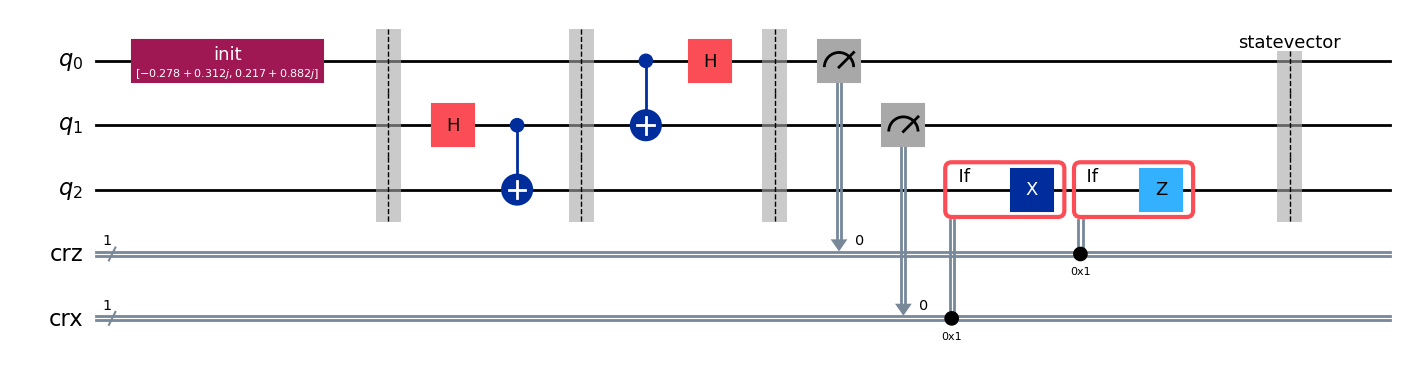

In [202]:
qr = QReg(3, name="q")
crz = CReg(1, name="crz")
crx = CReg(1, name="crx")
qc = QCir(qr, crz, crx)

# Step 0, initilize Alice's quubit q0 to psi
qc.append(init_gate, [0])
qc.barrier()

# Step 1: Entangle q1 and q2
create_bell_pair(qc, 1, 2)
qc.barrier()

# Step 2: Alice entangles her half of Bell pair with q0
alice_gates(qc, 0, 1)
qc.barrier()

# Step 3 : Alice measures q0 and q1 to classical register for Bob to read
measure_to_creg(qc, 0, 1)
qc.barrier

# Step 4: Bob uses classical register as controls for CX and CZ gates
bob_gates(qc, 2, crz, crx)

qc.save_statevector()
qc.draw(output="mpl", style="iqp")

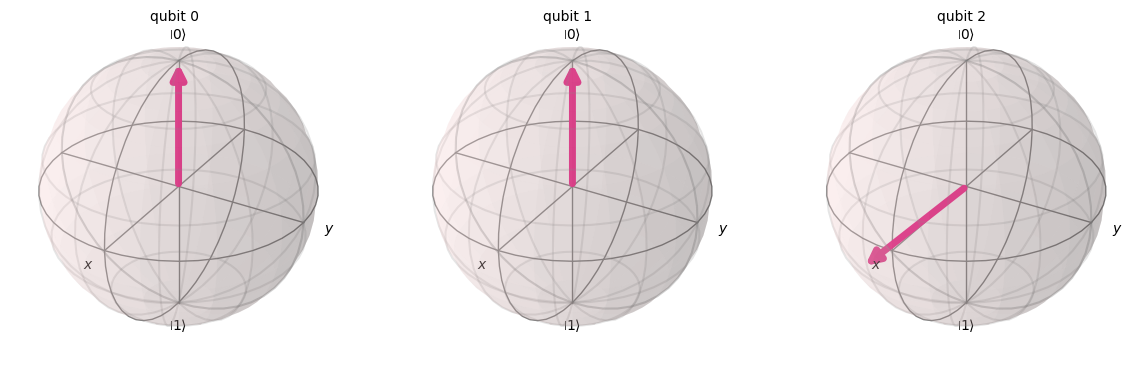

In [203]:
# Run circuit on aer simulation
out_vector = aer_simulator.run([qc]).result().get_statevector()
plot_bloch_multivector(out_vector)

Running multiple times gives different values for q0 and q1, but q2 is always the expected |psi>!

### Demonstrate via simulated counts

In [204]:
inverse_init_gate = init_gate.gates_to_uncompute()

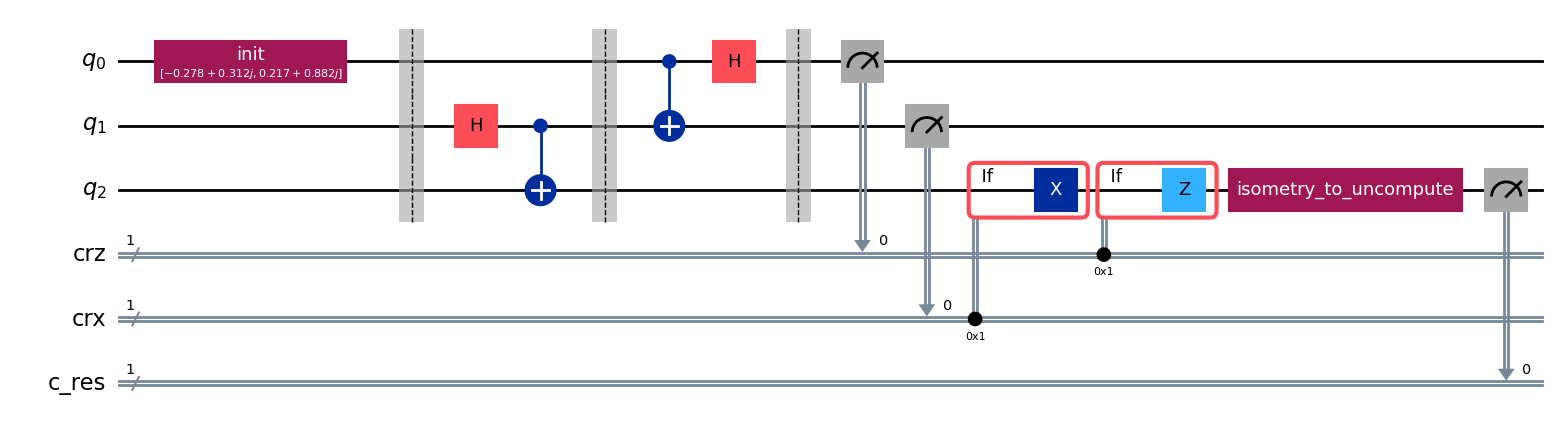

In [205]:
qr = QReg(3, name="q")
crz = CReg(1, name="crz")
crx = CReg(1, name="crx")
c_res = CReg(1, name="c_res")
qc = QCir(qr, crz, crx, c_res)

# Step 0, initilize Alice's quubit q0 to psi
qc.append(init_gate, [0])
qc.barrier()

# Step 1: Entangle q1 and q2
create_bell_pair(qc, 1, 2)
qc.barrier()

# Step 2: Alice entangles her half of Bell pair with q0
alice_gates(qc, 0, 1)
qc.barrier()

# Step 3 : Alice measures q0 and q1 to classical register for Bob to read
measure_to_creg(qc, 0, 1)
qc.barrier

# Step 4: Bob uses classical register as controls for CX and CZ gates
bob_gates(qc, 2, crz, crx)

# Step 5: Bob reverses the initialization
qc.append(inverse_init_gate, [2])

# Step 6: Measure Bob's qubit to the result register
qc.measure(2,2)

qc.draw(output="mpl", style="iqp")

### Transpile qc, run samples on simulator, and plot the results

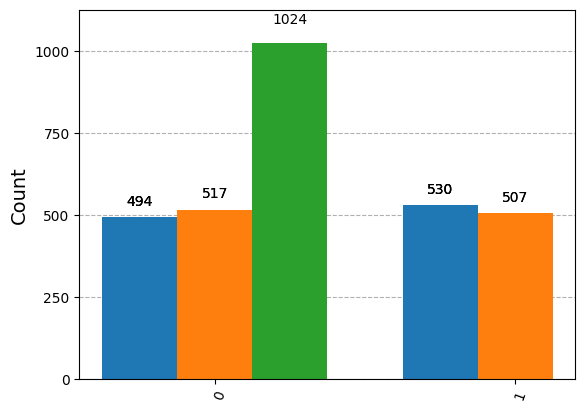

In [206]:
t_qc = transpile(qc, aer_simulator)
t_qc.save_statevector()
counts = aer_simulator.run(t_qc).result().get_counts()
qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(3)]
plot_histogram(qubit_counts)

This matches expectations, by reversing the initialization gate we've effectively returned q2 back to |0>

### Section 4 - Understanding Quantum Teleportation

To recap, we have a 3-qubit system: the qubit that we wish to teleport, |Ψ>, and the two qubits of the shared Bell-pair.

In [207]:
display(Math(r"|\psi\rangle = \alpha|0\rangle + \beta|1\rangle"))
display(Math(r"|\epsilon\rangle = \frac1{{\sqrt{2}}} (|00\rangle + |11\rangle)"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Combining, we get the intial state represented as

In [208]:
display(Math(r"""
    |\psi\rangle \otimes |\epsilon\rangle 
        =
    \frac1{{\sqrt{2}}}
    (\alpha|000\rangle + \alpha|011\rangle
        + \beta|100\rangle + \beta|111\rangle)
"""))

<IPython.core.display.Math object>

When Alice is ready to teleport |Ψ> to Bob, she first applies a CNOT gate, and then a Hadamard gate. Apply mathematically to get the following state

In [209]:
display(Math(r"""
(H \otimes I \otimes I)(CNOT \otimes I)(|\psi\rangle \otimes |\epsilon\rangle)
\\\\
= (H \otimes I \otimes I)(CNOT \otimes I)
[\frac1{{\sqrt{2}}}
    (\alpha|000\rangle + \alpha|011\rangle
        + \beta|100\rangle + \beta|111\rangle)]
\\\\
= (H \otimes I \otimes I)
[\frac1{{\sqrt{2}}}
    (\alpha|000\rangle + \alpha|011\rangle
        + \beta|110\rangle + \beta|101\rangle)]        
\\\\
= \frac12[
    \alpha(|000\rangle + |011\rangle + |100\rangle + |111\rangle) +
    \beta(|010\rangle + |001\rangle - |110\rangle - |101\rangle)
]
"""))

<IPython.core.display.Math object>

Can now be written in it's separable form

In [210]:
display(Math(r"""
(H \otimes I \otimes I)(CNOT \otimes I)(|\psi\rangle \otimes |\epsilon\rangle)
\\\\
= \frac12\Big(
    |00\rangle(\alpha|0\rangle + \beta|1\rangle)
\\\\\qquad+|01\rangle(\alpha|1\rangle + \beta|0\rangle)
\\\\\qquad+|10\rangle(\alpha|0\rangle - \beta|1\rangle)
\\\\\qquad+|11\rangle(\alpha|1\rangle - \beta|0\rangle)
\Big)
"""))

<IPython.core.display.Math object>

To finish retrieving the initial state |Ψ>, Bob now needs to use the classical bits of communication from Alice to determine what needs to be done. These classical bits correspond to the leading terms |00>, |01>, |10>, and |11> in the above equation. If the second bit is a 1, then Bob needs to apply the X gate; if the first bit is a 1, then Bob needs to apply Z gate. Regardless of Alice's measured values, this will always result in Bob now having his qubit in the original state |Ψ>.

For an example, let's examine what would happen if Alice measured "10" and sent this to Bob. This would imply that Bob's qubit is in the state (α|0> - β|1>). Following the instructions described, he would see that the second bit is a 0 so he does not apply the X gate; next he sees that the first bit is a 1 so he applies a Z gate. This results in (α|0> + β|1>), our desired |Ψ>!

### Teleportation on a Real Quantum Computer

Our previous results were either run on a simulation or using equations, neither are subjected to the realities of physical quantum hardware. This results in a disconnect between how the quantum circuit should be set up to run on real hardware, since the system does not currently support running instructions after taking qubit measurements. However, by having Bob's qubit go through CX and CZ gates that are controlled by Alice's qubits directly instead of classical bits, we can obtain the same result after moving measurement to the end of the circuit. This is known as the principle of deferred measurement.

Additionally, if you were to run the same circuit on current real quantum hardware, the result after the "disentangler" would not always be 0! This is due to noise causing disruptions in the qubits and gates, resulting in teleportation errors.

## Superdense Coding

Follow along with qiskit tutorial for superdense coding
https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/superdense-coding.ipynb

Superdense coding is a protocol that allows two bits of classical information to be sent with only a single qubit of information. This protocol is similar to quantum teleportation in that it relies on the entanglement of Bell states shared between participants, as well as using the qubit of one participant as the control for the CNOT gate of the other. However, the main differences are that there is no input qubit |Ψ>, and the result of the protocol is a set of classical bits as opposed to a qubit state.

### Performing superdense coding

The protocol begins similarly to quantum teleportation, we setup a Bell state and give one of the pair to each of Alice and Bob.

In [211]:
display(Math(r"|00\rangle = |0\rangle_A  \otimes |0\rangle_B"))
display(Math(r"(H \otimes I)(|00\rangle) = |+0\rangle = \frac1{\sqrt2}(|00\rangle + |10\rangle)"))
display(Math(r"CNOT(\frac1{\sqrt2}(|00\rangle + |10\rangle)) = \frac1{\sqrt2}(|00\rangle + |11\rangle)"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Once Alice has decided what 2-bit classical message to send, she needs to apply a corresponding gate(s) on her qubit. If she performs no operation, the message will be "00"; if she applies an X gate then the second bit will be flipped, "01"; if she applies a Z gate then the first bit will be flipped, "10"; or she can apply both, in that order, to send "11".

Regardless of what operations were applied to her qubit, Bob will always perform the same "restoration operation". This entails using Alice's qubit as the control for a CNOT gate on his qubit, and then a Hadamard gate on Alice's qubit. The resulting measurements will be a 2-bit message via a single bit of quantum communication!

### Simulating superdense coding

In [212]:
# Setup the 2-qubit circuit to use for superdense coding
sd_qc = QCir(2)
create_bell_pair(sd_qc, 0, 1)
sd_qc.draw()

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘

Setup the utility functions for the protocol

In [213]:
def encode_message(qc, qubit, msg):
    """
    Encodes a two-bit message on the qc using superdense coding protocol
        qc: QuantumCircuit
        qubit: index of qubit that is being sent "superdense"
        msg: Two-bit message to be sent
    """
    # Ensure msg is a string of two 0's or 1's
    if len(msg) != 2 or not set(msg).issubset({"0","1"}):
        raise ValueError(f"message '{msg}' is invalid binary message")
    if msg[1] == "1":
        qc.x(qubit)
    if msg[0] == "1":
        qc.z(qubit)

In [214]:
def decode_message(qc):
    """
    Decoding the message is always a CNOT and H gates
    """
    qc.cx(1,0)
    qc.h(1)

#### Simulate the protocol

In [215]:
# Set the message Alice will send
MESSAGE = "00"

sd_qc = QCir(2)
create_bell_pair(sd_qc, 1, 0)
sd_qc.barrier()

# q0 goes to Alice, q1 goes to Bob.

encode_message(sd_qc, 1, MESSAGE)
sd_qc.barrier()

# Alice sends her qubit to Bob

decode_message(sd_qc)

# Bob measures all qubits to read the full 2-bit message

sd_qc.measure_all()

sd_qc.draw()

┌───┐ ░  ░ ┌───┐      ░ ┌─┐   
   q_0: ─────┤ X ├─░──░─┤ X ├──────░─┤M├───
        ┌───┐└─┬─┘ ░  ░ └─┬─┘┌───┐ ░ └╥┘┌─┐
   q_1: ┤ H ├──■───░──░───■──┤ H ├─░──╫─┤M├
        └───┘      ░  ░      └───┘ ░  ║ └╥┘
meas: 2/══════════════════════════════╩══╩═
                                      0  1

### Visualize the results

{'00': 1024}


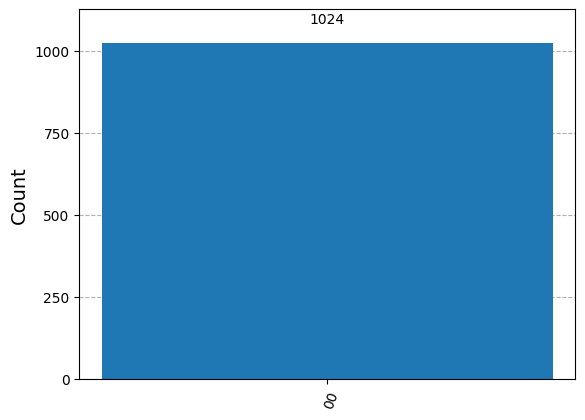

In [216]:
sd_results = aer_simulator.run([sd_qc]).result()
counts = sd_results.get_counts(sd_qc)
print(counts)
plot_histogram(counts)